In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
from functools import partial

import jax
from jaxtyping import Array, PRNGKeyArray, PyTree
from typing import Union, Callable, Generator, Literal
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
from jaxtyping import Array, PRNGKeyArray
import diffrax
import equinox as eqx
import optax

In [2]:
def dataprep(datafile, node):
    def create_path(i):
        filename = [filename for filename in os.listdir('Data/') if filename.startswith(str(i))][0]
        path1 = "Data/"
        path2 = filename

        return path1 + path2 + "/" + path2 + "_out.csv", path1 + path2 + "/" + path2 + "_U1_out.csv",path1 + path2 + "/" + path2 + "_U2_out.csv"

    def load_data(data_list, nodes):
        inp = np.empty((len(data_list), 1002, 2))
        pos = np.empty((len(data_list), 1002, len(nodes)))
        vel = np.empty((len(data_list), 1002, len(nodes)))
        acc = np.empty((len(data_list), 1002, len(nodes)))

        for i in range(len(data_list)):
            p,u1,u2 = create_path(data_list[i])
            pos[i] = np.loadtxt(open(p), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
            vel[i] = np.loadtxt(open(u1), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
            acc[i] = np.loadtxt(open(u2), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
        return pos,vel,acc

    pos, vel, acc = load_data(datafile, node)

    return pos, vel, acc

In [3]:
pos,vel,acc= dataprep([2220,2221,2222,2223,2224,2225], [0,17,18,33,34])
print (np.shape(pos))
print (np.shape(vel))
print(np.shape(acc))

(6, 1002, 5)
(6, 1002, 5)
(6, 1002, 5)


In [4]:
ts=pos[0,200:,0]
pos=pos[:,200:,1:]
vel=vel[:,200:,1:]
acc=acc[:,200:,1:]

In [5]:
abso_pos=jnp.abs(pos[0])
mean_mid_x=jnp.mean(abso_pos[:,0])
mean_mid_z=jnp.mean(abso_pos[:,1])
mean_end_x=jnp.mean(abso_pos[:,2])
mean_end_z=jnp.mean(abso_pos[:,3])

In [6]:
mean_mid_x

Array(0.00356603, dtype=float32)

In [7]:
pos[:,:,0]/=(mean_mid_x)
pos[:,:,2]/=(mean_end_x)
pos[:,:,1]/=(mean_mid_z)
pos[:,:,3]/=(mean_end_z)

vel[:,:,0]/=(mean_mid_x)
vel[:,:,2]/=(mean_end_x)
vel[:,:,1]/=(mean_mid_z)
vel[:,:,3]/=(mean_end_z)

acc[:,:,0]/=(mean_mid_x)
acc[:,:,2]/=(mean_end_x)
acc[:,:,1]/=(mean_mid_z)
acc[:,:,3]/=(mean_end_z)

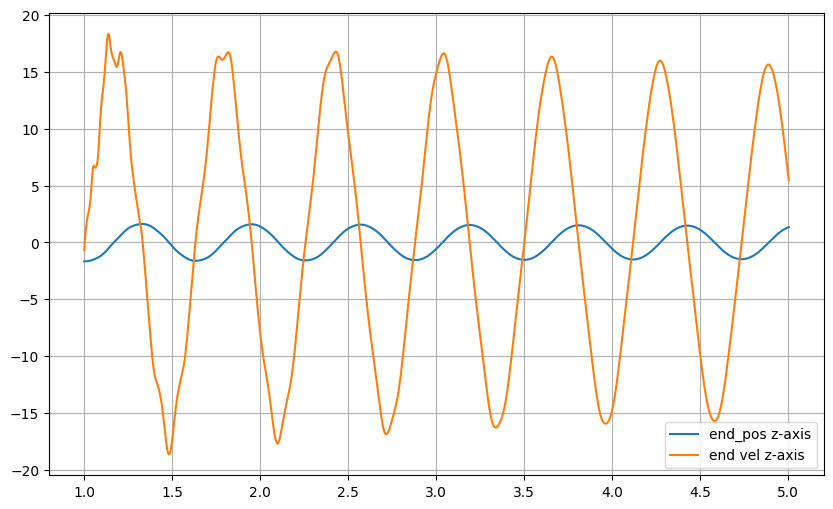

In [8]:
pos1_mid_x=pos[0,:,0]
pos1_mid=pos[0,:,1]
pos1_end_x=pos[0,:,2]
pos1_end=pos[0,:,3]
vel1_mid_x=vel[0,:,0]
vel1_mid=vel[0,:,1]
vel1_end_x=vel[0,:,2]
vel1_end=vel[0,:,3]
acc_mid_x=acc[0,:,0]
acc_mid=acc[0,:,1]
acc_end_x=acc[0,:,2]
acc_end=acc[0,:,3]

plt.figure(figsize=(10, 6))
plt.plot(ts, pos1_end, '-', label='end_pos z-axis')
plt.plot(ts, vel1_end, '-', label='end vel z-axis')
# plt.plot(ts, vel1_end_x, '-', label='end_vel_x')
# plt.plot(ts, vel1_end, '-', label='end vel')
# plt.plot(ts, acc_mid_x, '-', label='mid acc')
plt.legend()
plt.grid(True)
plt.show()

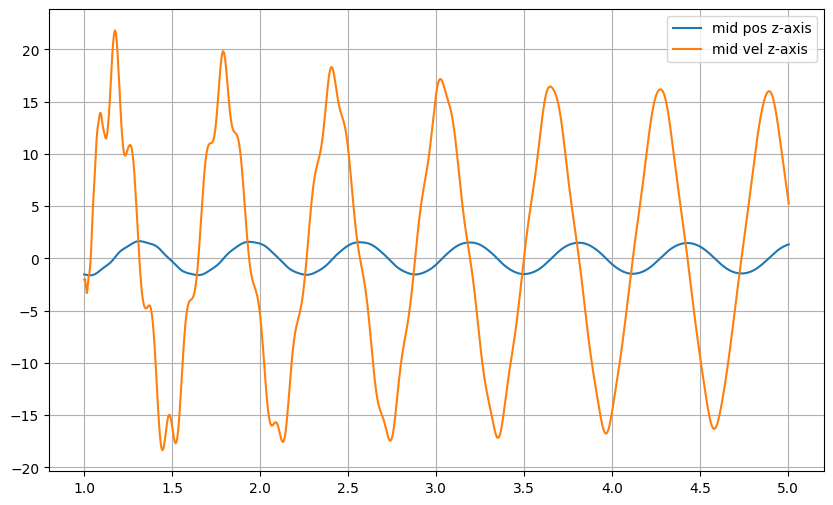

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos1_mid, '-', label='mid pos z-axis')
plt.plot(ts, vel1_mid, '-', label='mid vel z-axis')
# plt.plot(ts, vel1_end, '-', label='end_vel')
# plt.plot(ts, vel1_end_x, '-', label='end vel x')
plt.legend()
plt.grid(True)
plt.show()

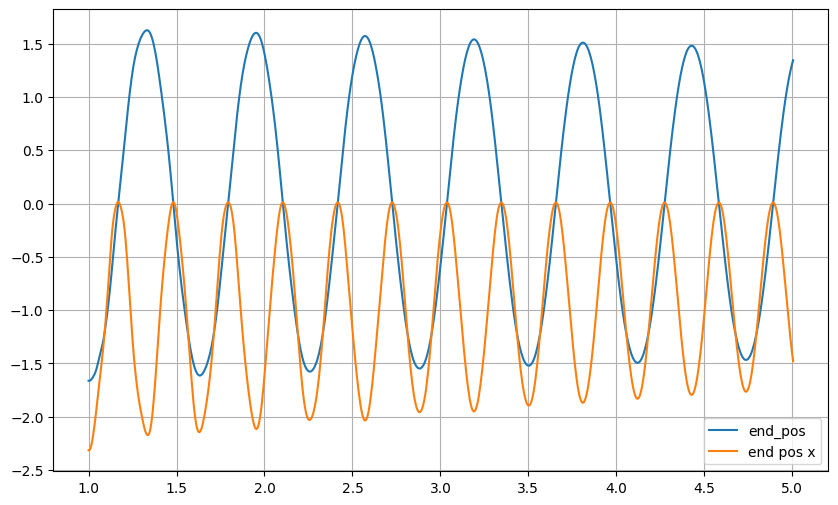

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos1_end, '-', label='end_pos')
plt.plot(ts, pos1_end_x, '-', label='end pos x')
plt.legend()
plt.grid(True)
plt.show()

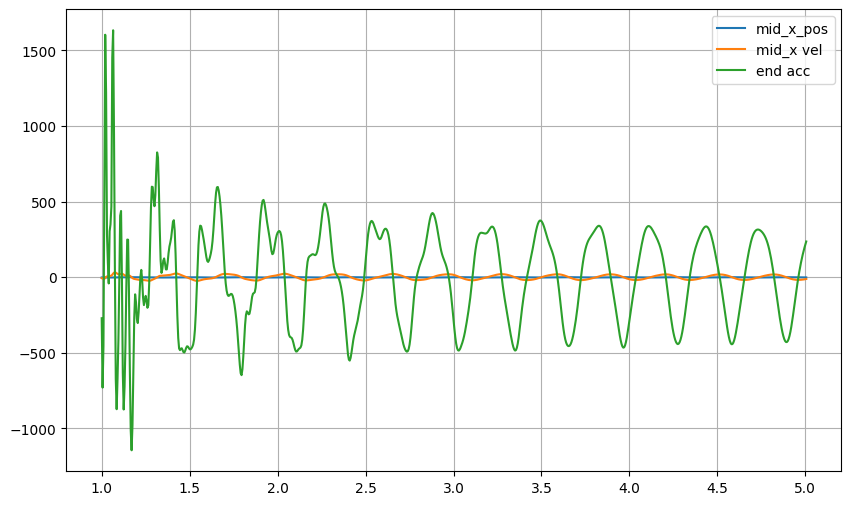

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos1_mid_x, '-', label='mid_x_pos')
plt.plot(ts, vel1_mid_x, '-', label='mid_x vel')
plt.plot(ts, acc_mid_x, '-', label='end acc')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
pos_vel=jnp.concat((pos,vel),axis=-1)
vel_acc=jnp.concat((vel,acc),axis=-1)

In [13]:
train_data=(pos_vel[0:5,:,:].reshape(-1, 8), vel_acc[0:5,:,:].reshape(-1, 8))
test_inp=pos_vel[5,:,:].reshape(-1,8)

In [14]:
train_data[0].shape

(4010, 8)

In [15]:
class LNNs(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, state_size:int, *, key:PRNGKeyArray, nn_width:int=16, nn_depth:int=2):
        super().__init__()

        assert state_size%2==0
        self.mlp =eqx.nn.MLP(state_size, 1, nn_width, nn_depth, jnn.softplus, key=key)

    def lagrangian(self, q, q_t):
        state = jnp.concat([q, q_t], axis=-1)   
        lagranigan = self.mlp(state)            
        return jnp.squeeze(lagranigan)      

    def __call__(self, state):
        q, q_t = jnp.split(state, 2)
        q_tt = jax.numpy.linalg.pinv(jax.hessian(self.lagrangian, 1)(q, q_t)) @ (
                    jax.grad(self.lagrangian, 0)(q, q_t)
                    - jax.jacfwd(jax.grad(self.lagrangian, 1), 0)(q, q_t) @ q_t)
        state_dot = jnp.concat([q_t, q_tt])
        return state_dot

In [16]:
def _dataloader(data: PyTree, batch_size:int, *, key:PRNGKeyArray, batch_mask: PyTree=None) -> Generator[PyTree, None, None]:

    # Generate an all true batch mask if None was passed
    if batch_mask is None:
        batch_mask = jax.tree.map(lambda x: x is not None, data)

    # Split the pytree according to the batch mask
    batched_data, unbatched_data = eqx.partition(data, batch_mask)

    # Check that all batch_mask data has the same batch dimension
    arrays_with_batch_dimension = jax.tree.leaves(batched_data)
    if len(arrays_with_batch_dimension) == 0:
        raise ValueError('At least one array should have a batch dimension.')
    dataset_size = arrays_with_batch_dimension[0].shape[0]
    if not all(array.shape[0] == dataset_size for array in arrays_with_batch_dimension[1:]):
        raise ValueError('All arrays with a batch axis should have the same shape along that axis.')

    # Convert to Numpy arrays. Numpy's slicing is much faster than jax's, so for fast model training steps this actually makes a huge difference!
    batched_data = jax.tree.map(lambda x: np.array(x), batched_data) 

    batch_size = min(batch_size, dataset_size)  # Reduce batch size if the dataset has less examples than batch size
    indices = jnp.arange(dataset_size)

    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start, end = 0, batch_size
        while end <= dataset_size:
            batch_indices = perm[start:end]
            bs = jax.tree.map(lambda x: x[batch_indices], batched_data)
            yield eqx.combine(bs, unbatched_data)
            start = end
            end = start + batch_size


In [17]:

def mse(pred, target, model):
    return jnp.mean((pred-target)**2)

def fit(model: PyTree,
        x: Array|tuple[Array, ...],
        y: Array|tuple[Array, ...],
        *,
        key: PRNGKeyArray,
        validation_data: tuple[Array|tuple[Array, ...], Array|tuple[Array, ...]] = None,
        batch_size: int = 32,
        batch_mask: PyTree[bool]|None = None,
        # lr: float = 3e-3,
        steps: int = 1000,
        log_loss_every: int = 10,
        loss_fn: Callable = mse,
        optimizer: optax.GradientTransformation = optax.adabelief(1e-3),
        ):

    if batch_mask is None:
        model_in_axes = 0
    else:
        model_in_axes = (jax.tree.map(lambda x: 0 if x else None, batch_mask[0]),)

    @eqx.filter_jit
    def get_loss(model, x, y):
        y_pred = jax.vmap(model, in_axes=model_in_axes)(x)
        return loss_fn(y, y_pred, model)
    
    grad_loss = eqx.filter_value_and_grad(get_loss)

    @eqx.filter_jit
    def make_step(x, y, flat_model, optimizer, flat_opt_state):
        model = jax.tree_util.tree_unflatten(treedef_model, flat_model)
        opt_state = jax.tree_util.tree_unflatten(treedef_opt_state, flat_opt_state)

        loss, grads = grad_loss(model, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params=eqx.filter(model, eqx.is_inexact_array))
        model = eqx.apply_updates(model, updates)

        flat_model = jax.tree_util.tree_leaves(model)
        flat_opt_state = jax.tree_util.tree_leaves(opt_state)

        return loss, flat_model, flat_opt_state

    history = {'log_loss_every': log_loss_every,
               'loss': [],}
    if validation_data is not None:
        vx, vy = validation_data
        history['val_loss'] = []

    val_loss = None

    # optimizer = optax.adabelief(lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

    flat_model, treedef_model = jax.tree_util.tree_flatten(model)
    flat_opt_state, treedef_opt_state = jax.tree_util.tree_flatten(opt_state)

    start_time = time.time()
    for step, (xi, yi) in zip(range(steps), 
                              _dataloader((x, y), batch_size, batch_mask=batch_mask, key=key)):
        loss, flat_model, flat_opt_state = make_step(xi, yi, flat_model, optimizer, flat_opt_state)

        if (step % log_loss_every) == 0 or step == steps - 1:
            model = jax.tree_util.tree_unflatten(treedef_model, flat_model)
            train_loss = get_loss(model, x, y)
            history['loss'].append(train_loss)
            if validation_data is not None:
                val_loss = get_loss(model, vx, vy)
                history['val_loss'].append(val_loss)
                print(f"Step: {step}, Loss: {train_loss:.3e}, Validation loss: {val_loss:.3e}")
            else:
                print(f"Step: {step}, Loss: {train_loss:.3e}")

    model = jax.tree_util.tree_unflatten(treedef_model, flat_model)

    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, history

In [18]:
key = jr.key(0)

model_key, loader_key = jr.split(key, 2)

lnn = LNNs(8,key=model_key,nn_width=16, nn_depth=2) 

lnn, losses = fit(lnn, train_data[0],train_data[1], key=loader_key, steps=60000,log_loss_every=10, optimizer= optax.adabelief(3e-3))

Step: 0, Loss: 1.365e+07
Step: 10, Loss: 5.076e+05
Step: 20, Loss: 5.847e+06
Step: 30, Loss: 5.967e+05
Step: 40, Loss: 2.706e+05
Step: 50, Loss: 1.405e+06
Step: 60, Loss: 1.717e+06
Step: 70, Loss: 1.736e+06
Step: 80, Loss: 9.179e+06
Step: 90, Loss: 3.286e+06
Step: 100, Loss: 1.872e+05
Step: 110, Loss: 2.543e+05
Step: 120, Loss: 2.572e+05
Step: 130, Loss: 5.034e+06
Step: 140, Loss: 2.027e+05
Step: 150, Loss: 1.433e+06
Step: 160, Loss: 3.004e+05
Step: 170, Loss: 9.521e+06
Step: 180, Loss: 2.140e+06
Step: 190, Loss: 1.411e+06
Step: 200, Loss: 1.429e+07
Step: 210, Loss: 1.335e+05
Step: 220, Loss: 2.306e+05
Step: 230, Loss: 1.477e+05
Step: 240, Loss: 1.581e+05
Step: 250, Loss: 1.330e+07
Step: 260, Loss: 3.939e+05
Step: 270, Loss: 4.461e+06
Step: 280, Loss: 9.004e+04
Step: 290, Loss: 6.549e+05
Step: 300, Loss: 2.006e+06
Step: 310, Loss: 6.915e+04
Step: 320, Loss: 9.022e+05
Step: 330, Loss: 1.414e+05
Step: 340, Loss: 2.729e+05
Step: 350, Loss: 8.428e+04
Step: 360, Loss: 2.725e+05
Step: 370, L

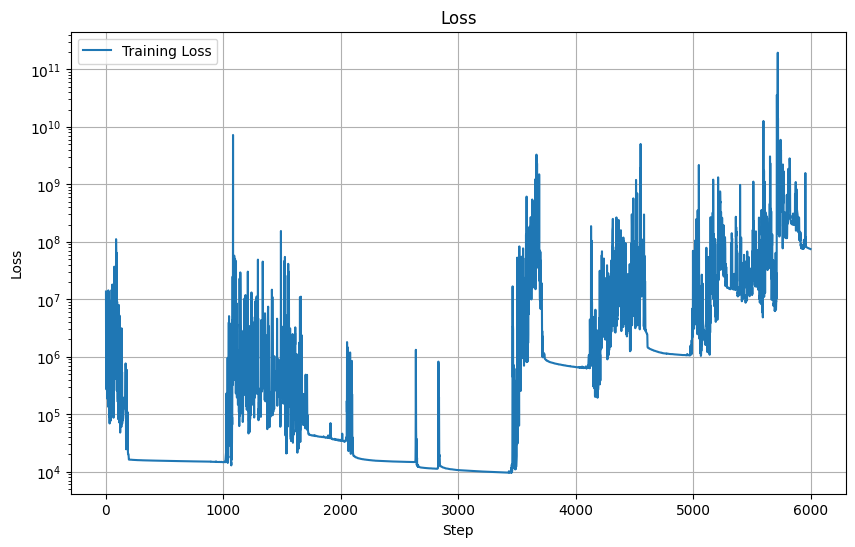

In [19]:
plt.figure(figsize=(10, 6))
plt.semilogy(losses['loss'], label='Training Loss')
plt.title('Loss'); plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(); plt.legend(); plt.show()

In [62]:
test_pred = np.zeros_like(test_inp)
test_pred=jax.vmap(lnn)(test_inp)

In [67]:
test_pred.shape

(802, 8)

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(ts, test_pred[:,6],'--', label='pred end_z acc')
plt.plot(ts,acc[5,:,2],'-',label='actual end_z acc')
# plt.plot(ts, test_pred[:,5],'-', label='pred mid acc')
# plt.plot(ts, test_pred[:,6],'-', label='pred mid acc')
# plt.plot(ts, test_pred[:,7],'-', label='pred mid acc')



# plt.plot(ts, test_pred[:,0],'-', label='pred vel')
# plt.plot(ts,test_deri[:,0],'-',label='smooth vel')
# plt.plot(ts, test_pred[:,1],'-', label='pred acc')
# plt.plot(ts,test_deri[:,1],'-',label='derived acc')

plt.legend()
plt.grid(True)
plt.show()

In [59]:
class ODESolver(eqx.Module):
    func: eqx.Module
    stepsize_controller: diffrax.AbstractStepSizeController
    solver: diffrax.AbstractSolver

    def __init__(self, func, **kwargs):
        super().__init__()

        self.solver = kwargs.pop('solver', diffrax.Tsit5())
        self.stepsize_controller = kwargs.pop('stepsize_controller', diffrax.PIDController(rtol=1e-6, atol=1e-6))

        self.func = func

    def __call__(self, ts:Array, y0:Array,u:Array=None) -> Array:

        def _func(t, y, args):
            return self.func(y)

        # Solve the ODE using diffrax
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(_func),
            self.solver,
            t0=ts[0], t1=ts[-1], 
            dt0=ts[1] - ts[0], y0=y0,
            stepsize_controller=self.stepsize_controller,
            saveat=diffrax.SaveAt(ts=ts),
        )

        return solution.ys

In [71]:
lnn_ode = ODESolver(lnn)

y0 = test_inp[0]
n=100
ts_plot = ts[:n]

y_pred = lnn_ode(ts_plot, y0)

In [72]:
ac_pos1_x_mid=test_inp[:n,0]
ac_pos1_mid=test_inp[:n,1]
ac_pos1_x_end=test_inp[:n,2]
ac_pos1_end=test_inp[:n,3]
ac_vel1_x_mid=test_inp[:n,4]
ac_vel1_mid=test_inp[:n,5]
ac_vel1_x_end=test_inp[:n,6]
ac_vel1_end=test_inp[:n,7]

pred_pos1_x_mid=y_pred[:,0]
pred_pos1_mid=y_pred[:,1]
pred_pos1_x_end=y_pred[:,2]
pred_pos1_end=y_pred[:,3]
pred_vel1_x_mid=y_pred[:,4]
pred_vel1_mid=y_pred[:,5]
pred_vel1_x_end=y_pred[:,6]
pred_vel1_end=y_pred[:,7]



plt.figure(figsize=(10, 6))
plt.plot(ts_plot, ac_pos1_end, '--', label='act_end_pos')
plt.plot(ts_plot, ac_vel1_end, '--', label='act end vel')
plt.plot(ts_plot, pred_pos1_end, label='pred end pos')
plt.plot(ts_plot,pred_vel1_end,label='pred end vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts_plot, ac_pos1_mid,'--', label='act_mid_pos')
plt.plot(ts_plot, ac_vel1_mid,'--', label='act mid vel')
plt.plot(ts_plot, pred_pos1_mid, label='pred mid vel')
plt.plot(ts_plot,pred_vel1_mid,label='pred mid vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts_plot, ac_pos1_x_end, '--', label='act_x_end_pos')
plt.plot(ts_plot, ac_vel1_x_end, '--', label='act end vel')
plt.plot(ts_plot, pred_pos1_x_end, label='pred end pos')
plt.plot(ts_plot,pred_vel1_x_end,label='pred end vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts_plot, ac_pos1_x_mid, '--', label='act_x_mid_pos')
plt.plot(ts_plot, ac_vel1_x_mid, '--', label='act mid vel')
plt.plot(ts_plot, pred_pos1_x_mid, label='pred mid pos')
plt.plot(ts_plot,pred_vel1_x_mid,label='pred mid vel')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:,0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, optim, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def train(
    model, training_data,
    *, key,
    batch_size=32,
    lr=1e-4,
    steps=1000,
    print_every=100,
    ):

    ts, ys = training_data
    
    losses = []

    start_time = time.time()
    optim = optax.adabelief(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, (_ys,) in zip(
        range(steps), _dataloader((ys, ), batch_size, key=key)
    ):
        loss, model, opt_state = make_step(ts, _ys, model, optim, opt_state)
        losses.append(loss)
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss:.3e}")
    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, losses

In [23]:
lnn_ode = ODESolver(lnn)
trajectory_data = (ts, pos_vel)

lnn_ode, losses = train(lnn_ode, trajectory_data, key=loader_key, steps=2000, lr=1e-3, print_every=50)

Step: 0, Loss: 5.045e-02
Step: 50, Loss: 2.457e-02


jax.pure_callback failed
Traceback (most recent call last):
  File "c:\Users\yajur\anaconda3\envs\jax_env\Lib\site-packages\jax\_src\callback.py", line 79, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "c:\Users\yajur\anaconda3\envs\jax_env\Lib\site-packages\jax\_src\callback.py", line 64, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yajur\anaconda3\envs\jax_env\Lib\site-packages\equinox\_errors.py", line 70, in raises
    raise EqxRuntimeError(msgs[_index.item()])
equinox._errors.EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


XlaRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.
-------
This error occurred during the runtime of your JAX program. Setting the environment
variable `EQX_ON_ERROR=breakpoint` is usually the most useful way to debug such errors.
(This can be navigated using most of the usual commands for the Python debugger:
`u` and `d` to move through stack frames, the name of a variable to print its value,
etc.) See also `https://docs.kidger.site/equinox/api/errors/#equinox.error_if` for more
information.


In [48]:
plt.figure(figsize=(10, 6))
plt.semilogy(losses, label='Training Loss')
plt.title('Loss'); plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(); plt.legend(); plt.show()
plt.legend()
plt.grid(True)
plt.show()

In [49]:
y0 = test_inp[0]

y_pred = lnn_ode(ts, y0)

In [25]:
# test_inp=test_inp.at[:, 0].divide(10)
# test_inp=test_inp.at[:, 4].divide(10)

In [26]:
# y_pred=y_pred.at[:,0].divide(10)
# y_pred=y_pred.at[:,4].divide(10)

In [51]:
ac_pos1_x_mid=test_inp[:,0]
ac_pos1_mid=test_inp[:,1]
ac_pos1_x_end=test_inp[:,2]
ac_pos1_end=test_inp[:,3]
ac_vel1_x_mid=test_inp[:,4]
ac_vel1_mid=test_inp[:,5]
ac_vel1_x_end=test_inp[:,6]
ac_vel1_end=test_inp[:,7]

pred_pos1_x_mid=y_pred[:,0]
pred_pos1_mid=y_pred[:,1]
pred_pos1_x_end=y_pred[:,2]
pred_pos1_end=y_pred[:,3]
pred_vel1_x_mid=y_pred[:,4]
pred_vel1_mid=y_pred[:,5]
pred_vel1_x_end=y_pred[:,6]
pred_vel1_end=y_pred[:,7]



plt.figure(figsize=(10, 6))
plt.plot(ts, ac_pos1_end, '--', label='act_end_pos')
plt.plot(ts, ac_vel1_end, '--', label='act end vel')
plt.plot(ts, pred_pos1_end, label='pred end pos')
plt.plot(ts,pred_vel1_end,label='pred end vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, ac_pos1_mid,'--', label='act_mid_pos')
plt.plot(ts, ac_vel1_mid,'--', label='act mid vel')
plt.plot(ts, pred_pos1_mid, label='pred mid vel')
plt.plot(ts,pred_vel1_mid,label='pred mid vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, ac_pos1_x_end, '--', label='act_x_end_pos')
plt.plot(ts, ac_vel1_x_end, '--', label='act end vel')
plt.plot(ts, pred_pos1_x_end, label='pred end pos')
plt.plot(ts,pred_vel1_x_end,label='pred end vel')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, ac_pos1_x_mid, '--', label='act_x_mid_pos')
plt.plot(ts, ac_vel1_x_mid, '--', label='act mid vel')
plt.plot(ts, pred_pos1_x_mid, label='pred mid pos')
plt.plot(ts,pred_vel1_x_mid,label='pred mid vel')
plt.legend()
plt.grid(True)
plt.show()